##Experiments with Crop Improvements

This notebook experiments advances in image cropping. This performs the following steps

1. determine dimensions of the image
2. determine the center of the image
3. zeroify the borders of the image to get rid of non-black background and edge distortions
4. crop to the new size of the image

In [1]:
import os
import skimage
from skimage import io, util
from skimage.draw import circle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

###Non-Cropped image case
Load some image that is not cropped.

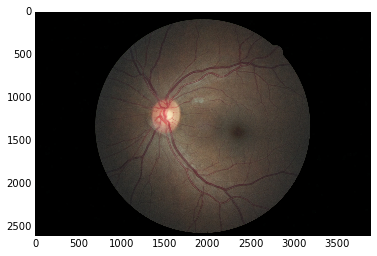

In [18]:
baseFolder = '/Users/boris/Dropbox/Kaggle/Retina/train/sample'
imgFile = '78_left.jpeg'
filename = os.path.join(baseFolder, imgFile)
img = io.imread(filename)
plt.imshow(img)

The simplest way to detect edges for cropping of a circular image with dark background is to sum up along different axes. Let's see how it works. First we sum up all the color channels, then compute horizontal and vertical borders.

In [19]:
threshold = 20000

s = np.sum(img, axis=2)
cols = np.sum(s, axis=0) > threshold  
rows = np.sum(s, axis=1) > threshold

now compute borders of the image

In [20]:
height = rows.shape[0]
width = cols.shape[0]

x_min = np.argmax(cols[0:width])
x_max = width/2 + np.argmin(cols[width/2:width-1])
y_min = np.argmax(rows[0:height/2])
y_max = height/2 + np.argmin(cols[height/2:height-1])

This is simple case, not trimmed image. Let's determine the radius and center of it. We reduce the radius in orger to get rid of the edge distortions

In [21]:
radius = (x_max - x_min)/2
center_x = x_min + radius
center_y = y_min + radius
radius1 = radius - 100

Now we zeroify everything outside the circle determined above. We need to do this as the black background actually not trully black.

In [22]:
mask = np.zeros(img.shape)
rr, cc = circle(center_y, center_x, radius1, img.shape)
mask[rr, cc] = 1
img *= mask

and now we are ready to do actual crop of the image. Perform the very same crop operation on the mask for further processing.

In [23]:
x_borders = (center_x - radius1, img.shape[1] - center_x - radius1)
y_borders = (center_y - radius1, img.shape[0] - center_y - radius1)

img2 = util.crop(img, (y_borders, x_borders,  (0,0)))
maskT = util.crop(mask, (y_borders, x_borders,  (0,0)))

border_pixels = np.sum(1 - maskT)

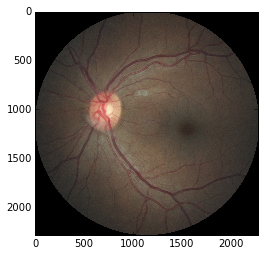

In [24]:
plt.imshow(img2)

###Cropped Image Case

now let's experiment with cropped image

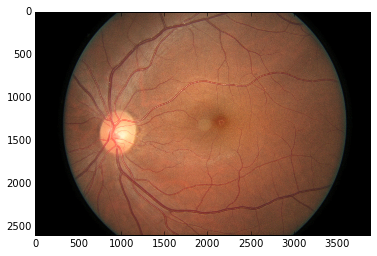

In [25]:
baseFolder = '/Users/boris/Dropbox/Kaggle/Retina/train/sample'
imgFile = '263_right.jpeg'
filename = os.path.join(baseFolder, imgFile)
img = skimage.io.imread(filename)
plt.imshow(img)

In [26]:
s = np.sum(img, axis=2)
cols = np.sum(s, axis=0) > threshold  
rows = np.sum(s, axis=1) > threshold

now compute borders of the image

In [27]:
threshold = 20000
height = rows.shape[0]
width = cols.shape[0]

x_min = np.argmax(cols[0:width])
x_max = width/2 + np.argmin(cols[width/2:width-1])
y_min = np.argmax(rows[0:height/2])
y_max = np.argmin(cols[height/2:height-1])
y_max = height/2 + y_max if y_max > 0 else height

print x_min, x_max, y_min, y_max, height/2

322 3608 0 2592 1296


And radius and the center of the image. If we have at least upper or lower side of the disk non-cropped, use it to determine the vertical center. Otherwise use Pithagoras theorem :-)

In [28]:
radius = (x_max - x_min)/2
center_x = x_min + radius
center_y = y_min + radius # the default case (if y_min != 0)
if y_min == 0: # the upper side is cropped
    if height - y_max > 0: # lower border is not 0
        center_y = y_max - radius
    else:
        upper_line_width = np.sum(s[0,:] > 100) # threshold for single line
        center_y = math.sqrt( radius**2 - (upper_line_width/2)**2)
radius1 = radius - 200

In [29]:
mask = np.zeros(img.shape[0:2])
rr, cc = circle(center_y, center_x, radius1, img.shape)
mask[rr, cc] = 1
img[:,:,0] *= mask
img[:,:,1] *= mask
img[:,:,2] *= mask

In [30]:
x_borders = (center_x - radius1, img.shape[1] - center_x - radius1)
y_borders = (max(center_y - radius1,0), max(img.shape[0] - center_y - radius1, 0))

img2 = util.crop(img, (y_borders, x_borders,  (0,0)))
maskT = util.crop(mask, (y_borders, x_borders))

border_pixels = np.sum(1 - maskT)

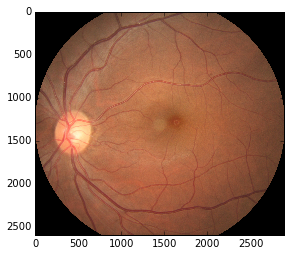

In [31]:
plt.imshow(img2)

and now putting everything together

In [13]:
def circularcrop(img, border, threshold, threshold1):
    s = np.sum(img, axis=2)
    cols = np.sum(s, axis=0) > threshold  
    rows = np.sum(s, axis=1) > threshold
    
    height = rows.shape[0]
    width = cols.shape[0]

    x_min = np.argmax(cols[0:width])
    x_max = width/2 + np.argmin(cols[width/2:width-1])
    y_min = np.argmax(rows[0:height/2])
    y_max = np.argmin(cols[height/2:height-1])
    y_max = height/2 + y_max if y_max > 0 else height

    radius = (x_max - x_min)/2
    center_x = x_min + radius
    center_y = y_min + radius # the default case (if y_min != 0)
    if y_min == 0: # the upper side is cropped
        if height - y_max > 0: # lower border is not 0
            center_y = y_max - radius
        else:
            upper_line_width = np.sum(s[0,:] > threshold1) # threshold for single line
            center_y = math.sqrt( radius**2 - (upper_line_width/2)**2)
    radius1 = radius - border    
    
    mask = np.zeros(img.shape[0:2])
    rr, cc = circle(center_y, center_x, radius1, img.shape)
    mask[rr, cc] = 1
    img[:,:,0] *= mask
    img[:,:,1] *= mask
    img[:,:,2] *= mask 
    
    x_borders = (center_x - radius1, img.shape[1] - center_x - radius1)
    y_borders = (max(center_y - radius1,0), max(img.shape[0] - center_y - radius1, 0))

    imgres = util.crop(img, (y_borders, x_borders,  (0,0)))
    maskT = util.crop(mask, (y_borders, x_borders))

    border_pixels = np.sum(1 - maskT)
    
    return imgres, maskT, center_x, center_y, radius

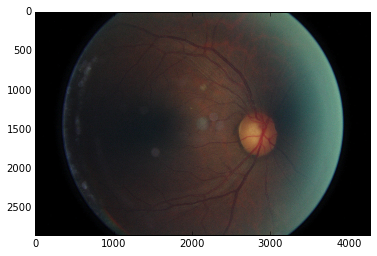

In [14]:
baseFolder = '/Users/boris/Dropbox/Shared/Retina'
imgFile = 'crop/20677_left.jpeg'
filename = os.path.join(baseFolder, imgFile)
img = io.imread(filename)
plt.imshow(img)

In [15]:
(imgA, maskA, x,y,r) = circularcrop(img, 200, 20000, 100)

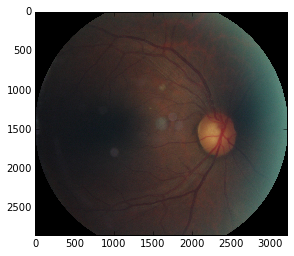

In [16]:
plt.imshow(imgA)

In [17]:
img.shape[0:2]

(2848L, 4272L)